# THINGS-fMRI usage notes

For a detailed description of the data and the procedures that generated it, see [the THINGS-data preprint](https://doi.org/10.1101/2022.07.22.501123).

In [49]:
from os.path import join as pjoin
import numpy as np
import pandas as pd
from nilearn.masking import apply_mask, unmask
from nilearn.plotting import plot_epi

In [39]:
# Let's assume you've downloaded the THINGS-fMRI data to this directory
basedir = '/Users/olivercontier/bigfri/openneuro/THINGS-data/THINGS-fMRI/derivatives'

## Single trial responses

The single trial responses are arguably the easiest way to analyze the THINGS-fMRI data. They contains the magnitude of the fMRI response to each stimulus in each voxel with a single number. The single trial responses are provided in two formats: a) In table format, b) in volumetric format.

### Table format

Besides the fMRI response data, the table format contains metadata about each voxel (such as noise ceilings, pRF parameters, regions of interest) and about the stimulus (such as image file name, trial type, run and session). 

In [38]:
# let's assume you downloaded the single trial responses in table format to this directory 
betas_csv_dir = pjoin(basedir, 'betas_csv')

# and that you're interested in the data for the first subject
sub = '01'

The `ResponseData.h5` files contain the actual single trial responses. Rows are voxels, columns are trials.

In [30]:
data_file = pjoin(betas_csv_dir, f'sub-{sub}_ResponseData.h5')
responses = pd.read_hdf(data_file)  # this may take a minute
print('Single trial response data')
responses.head()

Single trial response data


,voxel_id,0,1,2,3,4,5,6,7,8,...,9830,9831,9832,9833,9834,9835,9836,9837,9838,9839
0,0,-0.089022,0.041923,0.169130,-0.075151,0.015963,-0.010098,-0.012468,0.084902,0.091878,...,0.024178,-0.029775,0.099759,0.006796,-0.044169,0.018878,-0.057514,0.055157,-0.036201,-0.068705
1,1,-0.062508,-0.037973,-0.009769,0.082478,0.056631,-0.015929,-0.027017,0.054912,0.017544,...,-0.071025,0.035286,0.066276,-0.092530,-0.074624,0.006528,0.005477,0.002302,0.074685,-0.096532
2,2,-0.070807,-0.019326,-0.019546,-0.060038,-0.024878,0.052750,0.163108,0.037861,-0.073247,...,0.045679,0.075059,-0.020386,-0.034966,-0.027783,0.011068,-0.025219,0.012350,0.029529,0.006157
3,3,0.006218,0.016355,-0.075845,-0.109495,-0.007062,0.144785,0.086463,-0.047257,0.011348,...,-0.050225,0.016627,0.083943,-0.038645,-0.014257,0.050435,0.032841,-0.036794,-0.000256,0.033482
4,4,-0.014344,-0.029792,0.136358,-0.118176,0.007145,0.036102,0.036816,0.015313,0.035015,...,-0.104036,-0.020143,0.063932,-0.080900,0.010575,-0.015148,-0.085487,0.118670,0.073392,-0.014972


The `VoxelMetadata.csv` files contain additional information about each voxel, such as membership to ROIs, reliability measures, and noise ceilings.

In [24]:
vox_f = pjoin(betas_csv_dir, f'sub-{sub}_VoxelMetadata.csv')
voxdata = pd.read_csv(vox_f)
voxdata.head()

,voxel_id,subject_id,voxel_x,voxel_y,voxel_z,nc_singletrial,nc_testset,splithalf_uncorrected,splithalf_corrected,prf-eccentricity,...,lSTS,rSTS,lPPA,rPPA,lRSC,rRSC,lTOS,rTOS,lLOC,rLOC
0,0,1,1,39,33,0.000000,0.000000,-0.030530,-0.062982,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,39,34,1.102513,11.799193,0.070108,0.131029,4.941197,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,39,35,2.134454,20.743164,0.121099,0.216036,11.064742,...,0,0,0,0,0,0,0,0,0,0
3,3,1,1,39,36,0.000000,0.000000,-0.040901,-0.085290,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,4,1,1,40,33,0.446367,5.105714,0.034924,0.067491,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [31]:
print('available voxel metadata:\n', voxdata.columns.to_list())

available voxel metadata:
 ['voxel_id', 'subject_id', 'voxel_x', 'voxel_y', 'voxel_z', 'nc_singletrial', 'nc_testset', 'splithalf_uncorrected', 'splithalf_corrected', 'prf-eccentricity', 'prf-polarangle', 'prf-rsquared', 'prf-size', 'V1', 'V2', 'V3', 'hV4', 'VO1', 'VO2', 'LO1 (prf)', 'LO2 (prf)', 'TO1', 'TO2', 'V3b', 'V3a', 'lEBA', 'rEBA', 'lFFA', 'rFFA', 'lOFA', 'rOFA', 'lSTS', 'rSTS', 'lPPA', 'rPPA', 'lRSC', 'rRSC', 'lTOS', 'rTOS', 'lLOC', 'rLOC']


The voxel indices can be used to reconstruct a volume, e.g. for visualizing results obtained from the single trial responses. Alternatively, the brain mask can be used for that purpose (see below). Membership of each voxel to the available ROIs is dummy coded, e.g. in `voxdata["V1"]` or `voxdata["rFFA"]`. The population receptive field parameters are encoded in the following columns: `prf-eccentricity`, `prf-polarangle`, `prf-size`, and `prf-rsquared`. Finally, different reliability estimates are available in the columns: `nc_testset`, `nc_singletrial`, `splithalf_uncorrected`, and `splithalf_corrected`.

The `StimulusMetadata.csv` files contain information about the file name of the image shown in each trial, which run and session a given trial occured in, and the trial_type. 

In [33]:
# Stimulus metadata
stim_f = pjoin(betas_csv_dir, f'sub-{sub}_StimulusMetadata.csv')
stimdata = pd.read_csv(stim_f)
stimdata.head()

,trial_type,session,run,subject_id,trial_id,stimulus
0,train,1,1,1,0,dog_12s.jpg
1,train,1,1,1,1,mango_12s.jpg
2,train,1,1,1,2,spatula_12s.jpg
3,test,1,1,1,3,candelabra_14s.jpg
4,train,1,1,1,4,panda_12s.jpg


> 🚨 **Trial types**
>
> The THINGS-fMRI experiment presented participants with three different trial types:
> - `train`: Participants passively viewed an object image.
> - `test`: Same as train, but these trials belonged to a set of 200 images which were presented in each session. It's main purpose is to allow for estimating the reliability of the single trial responses in a given voxel.
> - `catch`: Participants saw a non-object image and responded with a button press. This was included to ensure participants were engaged throughout the experiment.
>
> Note: Catch trials are excluded from the single trial responses in table format as they are likely not of interest for most applications. However, catch trials are included in the volumetric format in order to make it possible to account for them in analyses.

### Volumetric format

## Brain masks

The brain masks indicate wether a given voxel is located in the brain or not (`1: brain`, `0: not brain`). They can be used e.g. to create a nifti volume from the results you obtained from the single trial responses.

In [43]:
# Say you have used the single trial responses above to produce results.
# Say your results are an array of n elements, where n is the number of voxels within the brain.
results = np.random.randn(responses.shape[0])
results.shape

(211339,)

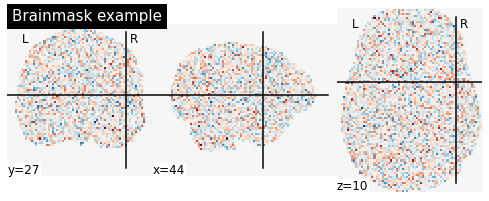

In [62]:
# you can easily use nilearn's masking functions to transform them 
# to an image object and save it as a nifti file

# This is the provided brain mask
bmask_dir = pjoin(basedir, 'brainmasks')
bmask_f = pjoin(bmask_dir, f'sub-{sub}_space-T1w_brainmask.nii.gz')

# use the brain mask to turn your results array into a 3D image
results_img = unmask(results, bmask_f)
# plot the image to verify
plot_epi(results_img, black_bg=False, title='Brainmask example', cmap='RdBu_r')
# and save it as an nifti file
results_img.to_filename('results.nii.gz')

> 🚨 **Co-registration and volumetric space**
>
> The THINGS-fMRI data was preprocessed with [fmriprep](https://fmriprep.org/en/stable/), which includes co-registration of all functional images to a high-resolution anatomical MRI image. In other words, all functional data for a given subject (including the brain masks aind regions of interest) was transformed into a common "space", meaning that a given voxel always points to the same location in the brain - with some level of imperfection.
> Of course, it's possible to analyze the data in a different space (e.g. MNI) by downloading the raw data and preprocessing it according to your needs.

## ICA noise regressors

## Regions of interest

## Cortical flat maps